# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
import seaborn as sns

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
megaline_calls=pd.read_csv('/datasets/megaline_calls.csv')
megaline_internet=pd.read_csv('/datasets/megaline_internet.csv')
megaline_sms=pd.read_csv('/datasets/megaline_messages.csv')
megaline_plans=pd.read_csv('/datasets/megaline_plans.csv')
megaline_users=pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
megaline_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
megaline_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


De el archivo de los planes se observa que tiene todos los datos, no hay valores auscentes y los tipo de datos de casi todosestán correctos, solo cambiaría el tipo de datos de  usd_monthly_pay y usd_per_gb de int a float, para que cuando se necesite hacer operaciones con la otras columnas que manejan precio en dolares todas sean de tipo float y no se pierda información sobre el dinero pagado al final por el cliente. 

## Corregir datos

In [5]:
#Se pasan las columnas de enteros a float
megaline_plans['usd_monthly_pay']=megaline_plans['usd_monthly_pay'].astype('float')
megaline_plans['usd_per_gb']=megaline_plans['usd_per_gb'].astype('float')

## Enriquecer los datos

In [6]:
#Se le agregas una columna con las gigas incluidas
megaline_plans['gb_per_month_included']=megaline_plans['mb_per_month_included']/1000
megaline_plans['gb_per_month_included']=megaline_plans['gb_per_month_included'].astype('int')

In [7]:
megaline_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20.0,10.0,0.03,0.03,surf,15
1,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate,30


## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Imprime una muestra de datos para usuarios
megaline_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
345,1345,Pasquale,Caldwell,26,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-07-12,surf,NaN
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12
161,1161,Florance,Estrada,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-27,ultimate,NaN
323,1323,Pamelia,Atkins,42,"Baltimore-Columbia-Towson, MD MSA",2018-12-30,surf,NaN
313,1313,Antoine,Baker,49,"San Francisco-Oakland-Berkeley, CA MSA",2018-05-24,surf,NaN
116,1116,Moriah,Yates,60,"Cincinnati, OH-KY-IN MSA",2018-08-08,surf,NaN
396,1396,Ardelia,Benton,65,"Salt Lake City, UT MSA",2018-06-01,surf,NaN
308,1308,Samara,Monroe,46,"Virginia Beach-Norfolk-Newport News, VA-NC MSA",2018-11-22,surf,NaN
499,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN
170,1170,Olin,Adkins,18,"Pittsburgh, PA MSA",2018-09-25,surf,NaN


Del archivo se ve que reg_date y churn_date es de tipo object se debería cambia a tipo datetime, chrun_date hay datos auscentes, y sabemos que estos datos ausentes significan que el usuario sigue con este plan. El resto no ay datos ausentes y están en el formato correcto. 

### Corregir los datos

In [10]:
#Se cambia el reg_date de object a datetime con formato Y-m-d
megaline_users['reg_date']=pd.to_datetime(megaline_users['reg_date'], format='%Y-%m-%d')

megaline_users['churn_date']=pd.to_datetime(megaline_users['churn_date'], format='%Y-%m-%d')

### Enriquecer los datos

In [11]:
#Obtener una columna con los meses en los que se suscribio
megaline_users['reg_month']=megaline_users['reg_date'].dt.month

## Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
megaline_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Imprime una muestra de datos para las llamadas
megaline_calls.sample(10)


,id,user_id,call_date,duration
137609,1499_78,1499,2018-12-26,0.00
29563,1112_72,1112,2018-12-30,4.34
52441,1187_634,1187,2018-11-06,0.00
90654,1328_284,1328,2018-10-14,0.00
50847,1183_191,1183,2018-12-02,2.46
65444,1237_51,1237,2018-10-24,0.00
100666,1359_550,1359,2018-10-20,0.00
15820,1062_60,1062,2018-05-11,8.78
136951,1496_120,1496,2018-12-31,11.94
46913,1170_1023,1170,2018-10-22,13.98


Del archivo se ve que call_date debe ser de tipo datetime y debido a que la compañia aproxima los segundos a minutos, es mejor aproximar la duración de cada llamada a el siguiente minuto.

### Corregir los datos

In [14]:
megaline_calls['call_date']=pd.to_datetime(megaline_calls['call_date'], format='%Y-%m-%d')

### Enriquecer los datos

In [15]:
#ver si hay filas duplicadas
print(megaline_calls.duplicated().sum())
#Ver si hay id duplicados
print(megaline_calls['id'].duplicated().sum())

0
0


In [16]:
#redondear los minutos al siguiente numero y se añade esta duración y se pone de tipo int
megaline_calls['rounded_duration']=megaline_calls['duration'].apply(np.ceil)
megaline_calls['rounded_duration']=megaline_calls['rounded_duration'].astype('int')

In [17]:
#sacar una columna con los meses 
megaline_calls['month_call']=megaline_calls['call_date'].dt.month

In [18]:
megaline_calls.sample(10)

,id,user_id,call_date,duration,rounded_duration,month_call
89645,1326_296,1326,2018-12-07,0.48,1,12
70978,1252_413,1252,2018-09-29,0.84,1,9
90573,1328_203,1328,2018-11-30,1.43,2,11
97486,1347_312,1347,2018-08-14,4.13,5,8
60023,1216_8,1216,2018-12-16,18.87,19,12
7830,1037_8,1037,2018-12-12,7.42,8,12
102592,1364_81,1364,2018-11-21,0.00,0,11
86928,1320_597,1320,2018-05-14,5.17,6,5
86083,1317_129,1317,2018-12-25,2.39,3,12
48246,1174_223,1174,2018-06-02,5.47,6,6


## Mensajes

In [19]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
megaline_sms.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [20]:
# Imprime una muestra de datos para los mensajes
megaline_sms.sample(10)


,id,user_id,message_date
47173,1320_417,1320,2018-08-01
30416,1192_54,1192,2018-12-08
71824,1467_156,1467,2018-05-03
62008,1388_2,1388,2018-12-25
21831,1132_1333,1132,2018-12-08
39436,1256_235,1256,2018-12-27
29013,1176_154,1176,2018-11-29
37312,1247_476,1247,2018-12-09
12925,1084_165,1084,2018-12-13
2630,1028_553,1028,2018-12-29


La información de message_date esta como object esta se debe convertir a tipo datatime, no hay datos ausentes, se debe revisar que no hayan filas duplicadas y que no hayan id duplicados, ya que este id es único para cada mensaje.

### Corregir los datos

In [21]:
megaline_sms['message_date']=pd.to_datetime(megaline_sms['message_date'], format='%Y-%m-%d')

### Enriquecer los datos

In [22]:
#ver si hay filas duplicadas
print(megaline_sms.duplicated().sum())
#ver si hay id duplicados
print(megaline_sms['id'].duplicated().sum())

0
0


In [23]:
#sacar una columna con los meses 
megaline_sms['message_month']=megaline_sms['message_date'].dt.month

## Internet

In [24]:
# Imprime la información general/resumida sobre el DataFrame de internet
megaline_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [25]:
# Imprime una muestra de datos para el tráfico de internet
megaline_internet.sample(10)


,id,user_id,session_date,mb_used
54642,1247_57,1247,2018-08-30,0.00
92658,1433_42,1433,2018-11-24,80.53
41568,1185_605,1185,2018-04-09,468.09
41102,1185_139,1185,2018-02-21,202.13
33379,1151_121,1151,2018-10-06,227.21
100012,1474_163,1474,2018-11-23,1159.27
48255,1214_629,1214,2018-05-28,508.70
19902,1090_134,1090,2018-08-30,329.85
72911,1339_48,1339,2018-11-28,519.43
59765,1268_434,1268,2018-08-21,372.20


Los datos en session_date se debe cambiar a un tipo de datos datetime, se ve que no hay datos ausentes. Se puede ver si hay filas duplicadas o id que estén duplicados.

### Corregir los datos

In [26]:
#cambian el formato a datetime
megaline_internet['session_date']=pd.to_datetime(megaline_internet['session_date'], format='%Y-%m-%d')

### Enriquecer los datos

In [27]:
#ver si hay filas duplicadas
print(megaline_internet.duplicated().sum())
#ver si hay id duplicadas
print(megaline_internet['id'].duplicated().sum())

0
0


In [28]:
megaline_internet['session_month']=megaline_internet['session_date'].dt.month

## Estudiar las condiciones de las tarifas

Se imprime la información de la las dos tarifas para ver sus condiciones

In [29]:
for i in range(2):
    print(f''' Nombre del plan: {megaline_plans['plan_name'][i]}
     Pago mensual: {megaline_plans['usd_monthly_pay'][i]}
     Minutos incluidos: {megaline_plans['minutes_included'][i]}
     Mensajes incluidos:{megaline_plans['messages_included'][i]}
     Gigas incluidas:{megaline_plans['mb_per_month_included'][i]}
     Minuto adicional(USD): {megaline_plans['usd_per_minute'][i]}
     Gigas adicional (usd):{megaline_plans['usd_per_gb'][i]}
     Mensajes adicionales(usd): {megaline_plans['usd_per_message'][i]}
     ''')
    

 Nombre del plan: surf
     Pago mensual: 20.0
     Minutos incluidos: 500
     Mensajes incluidos:50
     Gigas incluidas:15360
     Minuto adicional(USD): 0.03
     Gigas adicional (usd):10.0
     Mensajes adicionales(usd): 0.03
     
 Nombre del plan: ultimate
     Pago mensual: 70.0
     Minutos incluidos: 3000
     Mensajes incluidos:1000
     Gigas incluidas:30720
     Minuto adicional(USD): 0.01
     Gigas adicional (usd):7.0
     Mensajes adicionales(usd): 0.01
     


## Agregar datos por usuario



In [30]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user=megaline_calls.groupby(['user_id','month_call'])['id'].count()


In [31]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_month_per_user=megaline_calls.groupby(['user_id','month_call'])['rounded_duration'].sum()

In [32]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
sms_month_user=megaline_sms.groupby(['user_id','message_month'])['id'].count()

In [33]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

internet_month_per_user=megaline_internet.groupby(['user_id', 'session_month'])['mb_used'].sum()

Juntan los datos en un DataFrame dondde muestre lo que consumio cada usuario en el mes.

In [34]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

consumo_user=pd.concat([calls_per_user,minutes_month_per_user,sms_month_user,internet_month_per_user],axis=1).reset_index()
consumo_user.columns=['user_id','month','number_calls','minutes_used','sms_used','mb_used']

#Los meses que tienen nan en sms_used, giga y llamadas se cambian a 0
consumo_user['number_calls'].fillna(0,inplace=True)
consumo_user['minutes_used'].fillna(0,inplace=True)
consumo_user['sms_used'].fillna(0,inplace=True)
consumo_user['mb_used'].fillna(0,inplace=True)

consumo_user.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       2293 non-null   int64  
 1   month         2293 non-null   int64  
 2   number_calls  2293 non-null   float64
 3   minutes_used  2293 non-null   float64
 4   sms_used      2293 non-null   float64
 5   mb_used       2293 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 107.6 KB


In [35]:
# Añade la información de la tarifa, de users se obtiene cual es el plan de cada uno
consumo_plan=consumo_user.merge(megaline_users,on='user_id')[['user_id','month','number_calls','minutes_used','sms_used','mb_used','plan','city']]
consumo_plan.columns=['user_id','month','number_calls','minutes_used','sms_used','mb_used','plan_name','city']
consumo_plan

,user_id,month,number_calls,minutes_used,sms_used,mb_used,plan_name,city
0,1000,12,16.0,124.0,11.0,1901.47,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,27.0,182.0,30.0,6919.15,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,49.0,315.0,44.0,13314.82,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,65.0,393.0,53.0,22330.49,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,64.0,426.0,36.0,18504.30,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2288,1498,12,39.0,339.0,0.0,23137.69,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2289,1499,9,41.0,346.0,0.0,12984.76,surf,"Orlando-Kissimmee-Sanford, FL MSA"
2290,1499,10,53.0,385.0,0.0,19492.43,surf,"Orlando-Kissimmee-Sanford, FL MSA"
2291,1499,11,45.0,308.0,0.0,16813.83,surf,"Orlando-Kissimmee-Sanford, FL MSA"


In [36]:
# El data frame anterior se une con la información del plan 
final_consumo=consumo_plan.merge(megaline_plans,on='plan_name')
final_consumo

,user_id,month,number_calls,minutes_used,sms_used,mb_used,plan_name,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,12,16.0,124.0,11.0,1901.47,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30
1,1006,11,2.0,10.0,15.0,2068.37,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30
2,1006,12,9.0,59.0,139.0,32118.82,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30
3,1008,10,71.0,476.0,21.0,17106.99,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30
4,1008,11,63.0,446.0,37.0,23676.72,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,39.0,339.0,0.0,23137.69,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15360,500,20.0,10.0,0.03,0.03,15
2289,1499,9,41.0,346.0,0.0,12984.76,surf,"Orlando-Kissimmee-Sanford, FL MSA",50,15360,500,20.0,10.0,0.03,0.03,15
2290,1499,10,53.0,385.0,0.0,19492.43,surf,"Orlando-Kissimmee-Sanford, FL MSA",50,15360,500,20.0,10.0,0.03,0.03,15
2291,1499,11,45.0,308.0,0.0,16813.83,surf,"Orlando-Kissimmee-Sanford, FL MSA",50,15360,500,20.0,10.0,0.03,0.03,15


Calcula los ingresos mensuales por usuario 

In [37]:
#Se hace una función con las condiciones de cada plan
def additional_cost (row):
    monthly_pay=row['usd_monthly_pay']
    
    minutes_used=row['minutes_used']
    minutes_included=row['minutes_included']
    usd_per_minute=row['usd_per_minute']   
    
    mb_used=row['mb_used']
    mb_per_month_included=row['mb_per_month_included']
    usd_per_gb=row['usd_per_gb']
    
    sms_used=row['sms_used']
    sms_included=row['messages_included']
    usd_per_sms=row['usd_per_message']
    
    #Variable con el valor total que pago al mes cada usuario
    total_pay=monthly_pay
    
    #Se mira si gasto más minutos de los que incluye el plan, de ser así se suma el costo adicional
    if minutes_used>minutes_included:
        total_pay+=(minutes_used-minutes_included)*usd_per_minute
    else:
        total_pay=total_pay
        
    #Se mira las gb que uso y son más de las incluidas se cobra el adicional por gb    
    if mb_used>mb_per_month_included:
        extra_gb=math.ceil((mb_used-mb_per_month_included)/1000)
        total_pay+=extra_gb*usd_per_gb        
    else: 
        total_pay=total_pay
        
    #Se mira cuantos mensajes usaron y si usaron de más se cobra el adicional por mensaje
    if sms_used>sms_included:
        total_pay+=(sms_used-sms_included)*usd_per_sms
    else:
        total_pay=total_pay
    
    return total_pay

In [38]:
#Se usa la función y se adiciona una columan con el total pagado por mes para cada usuario
final_consumo['total_pay'] = final_consumo.apply(additional_cost, axis=1)
final_consumo

,user_id,month,number_calls,minutes_used,sms_used,mb_used,plan_name,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,total_pay
0,1000,12,16.0,124.0,11.0,1901.47,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30,70.0
1,1006,11,2.0,10.0,15.0,2068.37,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30,70.0
2,1006,12,9.0,59.0,139.0,32118.82,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30,84.0
3,1008,10,71.0,476.0,21.0,17106.99,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30,70.0
4,1008,11,63.0,446.0,37.0,23676.72,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,39.0,339.0,0.0,23137.69,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15360,500,20.0,10.0,0.03,0.03,15,100.0
2289,1499,9,41.0,346.0,0.0,12984.76,surf,"Orlando-Kissimmee-Sanford, FL MSA",50,15360,500,20.0,10.0,0.03,0.03,15,20.0
2290,1499,10,53.0,385.0,0.0,19492.43,surf,"Orlando-Kissimmee-Sanford, FL MSA",50,15360,500,20.0,10.0,0.03,0.03,15,70.0
2291,1499,11,45.0,308.0,0.0,16813.83,surf,"Orlando-Kissimmee-Sanford, FL MSA",50,15360,500,20.0,10.0,0.03,0.03,15,40.0


## Estudia el comportamiento de usuario

### Llamadas

In [39]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

##Del archivo completo obtengo la duración promedio de la llamadas para cada mes para el plan ultimate
#Filtra el archivo final_consumo por los que tengan plan ultimate
ultimate_call_duration=final_consumo[final_consumo['plan_name']=='ultimate'][['month','minutes_used']]
#De este filtro los agrupo por mes y obtengo la media de los minutos usados 
ultimate_call_duration_mean=ultimate_call_duration.groupby(['month'])['minutes_used'].mean()

##Del archivo completo obtengo la duración promedio de la llamadas para cada mes para el plan surf
#Filtra el archivo final_consumo por los que tengan plan surf
surf_call_duration=final_consumo[final_consumo['plan_name']=='surf'][['month','minutes_used']]
#De este filtro los agrupo por mes y obtengo la media de los minutos usados para este plan
surf_call_duration_mean=surf_call_duration.groupby(['month'])['minutes_used'].mean()

#Se crea un nuevo dataframe con los datos de la duración promedio de llamada por mes para cada plan 
surf_ultimate_calls=pd.concat([ultimate_call_duration_mean,surf_call_duration_mean],axis=1).reset_index()
surf_ultimate_calls.columns=['month','ultimate','surf']
surf_ultimate_calls

,month,ultimate,surf
0,1,193.500000,203.000000
1,2,403.142857,297.000000
2,3,304.250000,330.000000
3,4,336.857143,351.540000
4,5,406.241379,399.584416
5,6,370.957447,431.298969
6,7,427.067797,449.983471
7,8,421.436620,410.111111
8,9,437.511628,414.226804
9,10,450.735849,429.729958


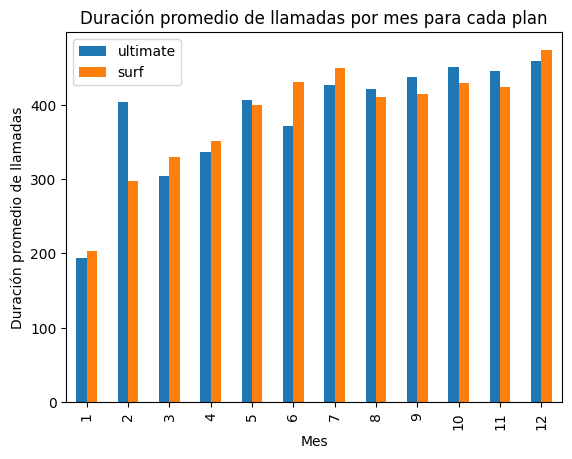

In [40]:
#Se crea un gráfico de barras para compara la duración promedio de llamadas por cada plan y por cada mes.
surf_ultimate_calls.plot(x='month',kind='bar', title='Duración promedio de llamadas por mes para cada plan',xlabel='Mes', ylabel='Duración promedio de llamadas')
plt.legend(['ultimate','surf'])
plt.show()

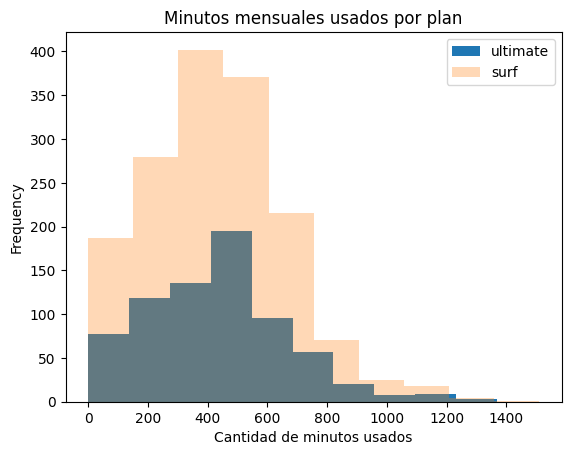

In [41]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

final_consumo[final_consumo['plan_name']=='ultimate']['minutes_used'].plot(kind='hist')
final_consumo[final_consumo['plan_name']=='surf']['minutes_used'].plot(kind='hist',alpha=0.3)
plt.legend(['ultimate','surf'])
plt.title('Minutos mensuales usados por plan')
plt.xlabel('Cantidad de minutos usados')
plt.show()

In [42]:
# Calcula la media y la varianza de la duración mensual de llamadas para el plan surf

surf_calls_mean=surf_ultimate_calls['surf'].mean()
surf_calls_varianza=np.var(surf_ultimate_calls['surf'])
print (f'la media de la duración de llamadas para el plan surf es:{surf_calls_mean}')
print (f'la varianza de la duración de llamadas para el plan surf es:{surf_calls_varianza}')

la media de la duración de llamadas para el plan surf es:384.4696912581946
la varianza de la duración de llamadas para el plan surf es:5369.551951906404


In [43]:
# Calcula la media y la varianza de la duración mensual de llamadas para el plan ultimate
ultimate_calls_mean=surf_ultimate_calls['ultimate'].mean()
ultimate_calls_varianza=np.var(surf_ultimate_calls['ultimate'])
print (f'la media de la duración de llamadas para el plan surf es:{ultimate_calls_mean}')
print (f'la varianza de la duración de llamadas para el plan surf es:{ultimate_calls_varianza}')

la media de la duración de llamadas para el plan surf es:387.99974229608006
la varianza de la duración de llamadas para el plan surf es:5472.540903753354


<AxesSubplot:xlabel='surf'>

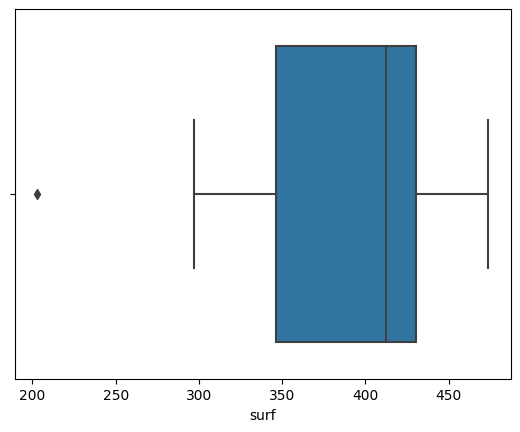

In [44]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas para plan surf
sns.boxplot(surf_ultimate_calls['surf'])


<AxesSubplot:xlabel='ultimate'>

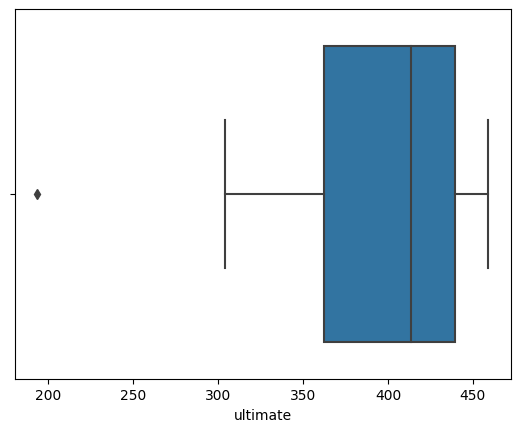

In [45]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas para plan ultimate
sns.boxplot(surf_ultimate_calls['ultimate'])

#### Conclusiones
El comportamiento de los usuarios respecto a el uso de minutos no varia mucho en función del plan que cada uno tiene. La media de los minutos usados en llamandas es muy similar en los dos planes. Para el plan surf es aproximadamente 384 y para el plan ultimate es de 387, la diferencia es muy mínima. De los diagramas se puede ver que realmente los usuarios no gastan más minutos de los que tienen en el plan. 

### Mensajes

In [46]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

##Del archivo completo obtengo los mensajes promedio para cada mes para el plan ultimate
#Filtra el archivo final_consumo por los que tengan plan ultimate
ultimate_sms=final_consumo[final_consumo['plan_name']=='ultimate'][['month','sms_used']]
#De este filtro los agrupo por mes y obtengo la media de los mensajes enviados
ultimate_sms_mean=ultimate_sms.groupby(['month'])['sms_used'].mean()

##Del archivo completo obtengo los mensajes promedio para cada mes para el plan surf
#Filtra el archivo final_consumo por los que tengan plan surf
surf_sms=final_consumo[final_consumo['plan_name']=='surf'][['month','sms_used']]
#De este filtro los agrupo por mes y obtengo la media de los mensajes usados para este plan
surf_sms_mean=surf_sms.groupby(['month'])['sms_used'].mean()

#Se crea un nuevo dataframe con los datos del promdeio de los mensajes usados por mes para cada plan 
surf_ultimate_sms=pd.concat([ultimate_sms_mean,surf_sms_mean],axis=1).reset_index()
surf_ultimate_sms.columns=['month','ultimate','surf']
surf_ultimate_sms

,month,ultimate,surf
0,1,15.500000,10.500000
1,2,21.571429,12.000000
2,3,20.250000,15.260870
3,4,22.047619,17.400000
4,5,32.103448,24.012987
5,6,29.340426,25.298969
6,7,32.830508,27.033058
7,8,38.478873,28.777778
8,9,37.895349,30.762887
9,10,39.443396,33.839662


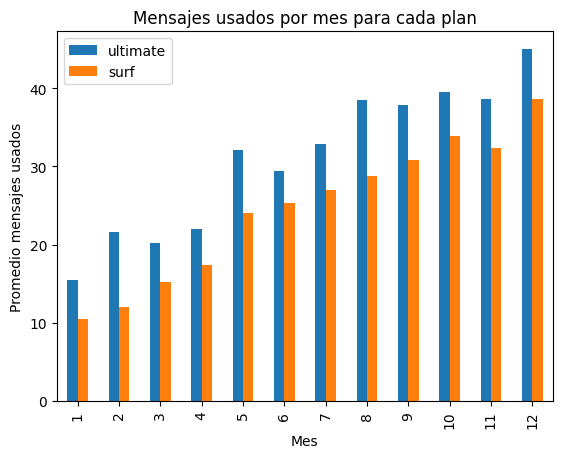

In [47]:
#Se crea un gráfico de barras para compara los mensajes usados por cada plan y por cada mes.
surf_ultimate_sms.plot(x='month',kind='bar', title='Mensajes usados por mes para cada plan',xlabel='Mes', ylabel='Promedio mensajes usados')
plt.legend(['ultimate','surf'])
plt.show()

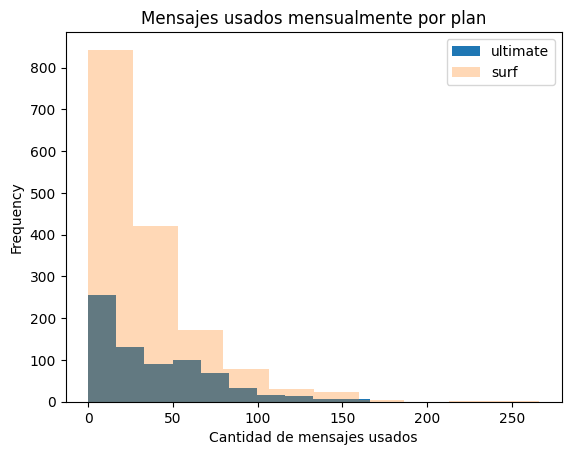

In [48]:
# Compara la cantidad de mensajes usados por usuarios por plan

final_consumo[final_consumo['plan_name']=='ultimate']['sms_used'].plot(kind='hist')
final_consumo[final_consumo['plan_name']=='surf']['sms_used'].plot(kind='hist',alpha=0.3)
plt.legend(['ultimate','surf'])
plt.title('Mensajes usados mensualmente por plan')
plt.xlabel('Cantidad de mensajes usados')
plt.show()

In [49]:
# Calcula la media y la varianza de los mensajes usados mensualmente para el plan surf

surf_sms_mean=surf_ultimate_sms['surf'].mean()
surf_sms_varianza=np.var(surf_ultimate_sms['surf'])
print (f'la media de los mensajes usados para el plan surf es:{surf_sms_mean}')
print (f'la varianza de los mensajes usados para el plan surf es:{surf_sms_varianza}')

la media de los mensajes usados para el plan surf es:24.655999855500053
la varianza de los mensajes usados para el plan surf es:75.06477581565973


In [50]:
# Calcula la media y la varianza de de los mensajes usados mensualmente para el plan ultimate

ultimate_sms_mean=surf_ultimate_sms['ultimate'].mean()
ultimate_sms_varianza=np.var(surf_ultimate_sms['ultimate'])
print (f'la media de los mensajes usados para el plan ultimate es:{ultimate_sms_mean}')
print (f'la varianza de los mensajes usados para el plan ultimate es:{ultimate_sms_varianza}')

la media de los mensajes usados para el plan ultimate es:31.08949749446805
la varianza de los mensajes usados para el plan ultimate es:80.07446628813626


<AxesSubplot:xlabel='surf'>

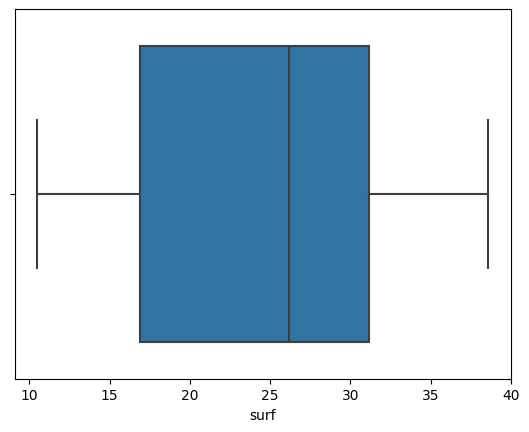

In [51]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes usados mensualmente para plan surf
sns.boxplot(surf_ultimate_sms['surf'])

<AxesSubplot:xlabel='ultimate'>

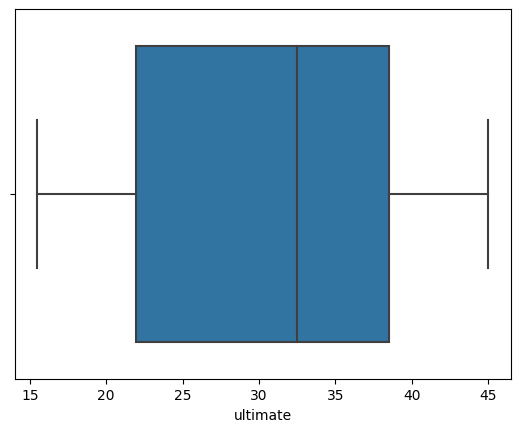

In [52]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes usados mensualmente para plan surf
sns.boxplot(surf_ultimate_sms['ultimate'])

#### Conclusiones
En el caso de el uso de los mensajes si se vio que vario la cantidad de mensajes usados en función del plan, en promedio los que tenían el plan ultimate usaron más que los que tenían el plan surf. También se puede observar que no hay usuarios que hayan gastado más de los mensajes que tenían incluidos en su plan.

### Internet

In [53]:
# Comprara la cantida de mb que tienden a usar cada mes los usuarios de cada plan

#Filtra el archivo final_consumo por los que tengan plan ultimate
ultimate_mb=final_consumo[final_consumo['plan_name']=='ultimate'][['month','mb_used']]
#De este filtro los agrupo por mes y obtengo la media de los mb usados
ultimate_mb_mean=ultimate_mb.groupby(['month'])['mb_used'].mean()


#Filtra el archivo final_consumo por los que tengan plan surf
surf_mb=final_consumo[final_consumo['plan_name']=='surf'][['month','mb_used']]
#De este filtro los agrupo por mes y obtengo la media los mb usados para este plan
surf_mb_mean=surf_mb.groupby(['month'])['mb_used'].mean()

#Se crea un nuevo dataframe con los datos de los mb usados por mes para cada plan 
surf_ultimate_mb=pd.concat([ultimate_mb_mean,surf_mb_mean],axis=1).reset_index()
surf_ultimate_mb.columns=['month','ultimate','surf']
surf_ultimate_mb

,month,ultimate,surf
0,1,6918.092500,4874.860000
1,2,17128.808571,12178.843333
2,3,18321.518333,13345.440000
3,4,16121.654762,11984.203000
4,5,16624.482414,13936.354935
5,6,15337.921064,15301.529175
6,7,16344.744407,16783.600579
7,8,17814.720141,16795.331358
8,9,16969.869535,16591.431289
9,10,17612.553396,17311.335063


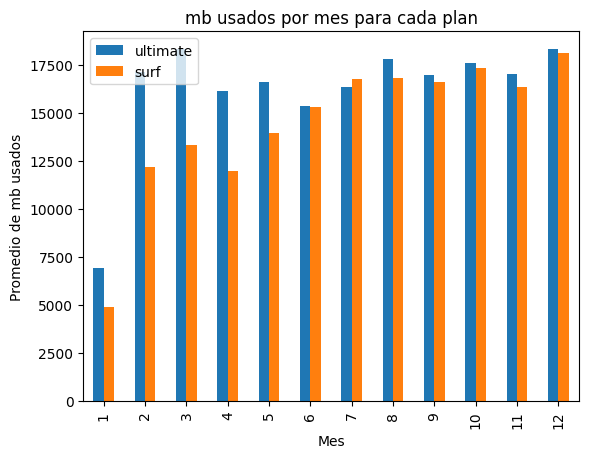

In [54]:
#Se crea un gráfico de barras para compara los mb usados por cada plan y por cada mes.
surf_ultimate_mb.plot(x='month',kind='bar', title='mb usados por mes para cada plan',xlabel='Mes', ylabel='Promedio de mb usados')
plt.legend(['ultimate','surf'])
plt.show()

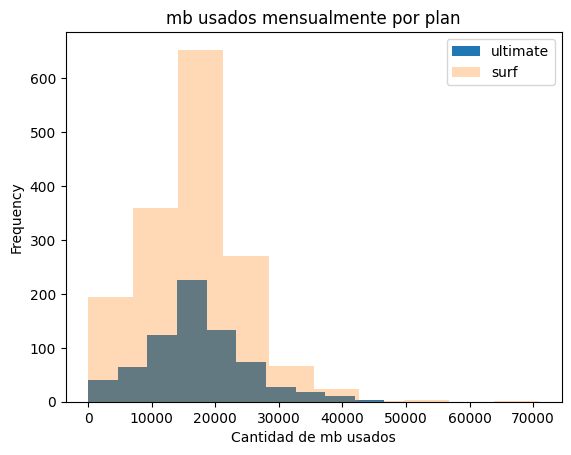

In [55]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

final_consumo[final_consumo['plan_name']=='ultimate']['mb_used'].plot(kind='hist', bins=10)
final_consumo[final_consumo['plan_name']=='surf']['mb_used'].plot(kind='hist',alpha=0.3, bins=10)
plt.legend(['ultimate','surf'])
plt.title('mb usados mensualmente por plan')
plt.xlabel('Cantidad de mb usados')
plt.show()

In [56]:
# Calcula la media y la varianza de los mb usados mensualmente para el plan surf

surf_mb_mean=surf_ultimate_mb['surf'].mean()
surf_mb_varianza=np.var(surf_ultimate_mb['surf'])
print (f'la media de mb usados para el plan surf es:{surf_mb_mean}')
print (f'la varianza de los mb usados para el plan surf es:{surf_mb_varianza}')

la media de mb usados para el plan surf es:14464.554376681192
la varianza de los mb usados para el plan surf es:12164763.13014511


In [57]:
# Calcula la media y la varianza de los mb usados mensualmente para el plan ultimate

ultimate_mb_mean=surf_ultimate_mb['ultimate'].mean()
ultimate_mb_varianza=np.var(surf_ultimate_mb['ultimate'])
print (f'la media de mb usados para el plan ultimate es:{ultimate_mb_mean}')
print (f'la varianza de los mb usados para el plan ultimate es:{ultimate_mb_varianza}')

la media de mb usados para el plan ultimate es:16212.603527638312
la varianza de los mb usados para el plan ultimate es:8572015.219625546


<AxesSubplot:xlabel='surf'>

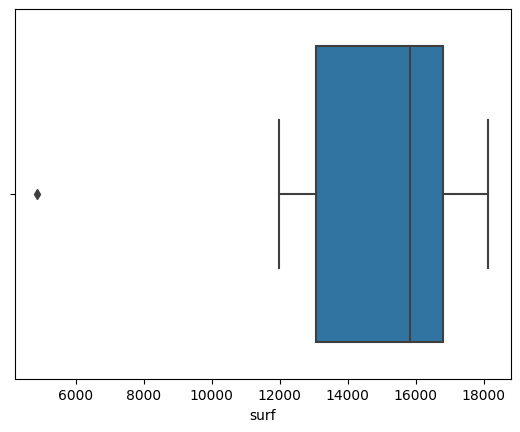

In [58]:
# Traza un diagrama de caja para visualizar la distribución de mb usados mensualmente para plan surf
sns.boxplot(surf_ultimate_mb['surf'])

<AxesSubplot:xlabel='ultimate'>

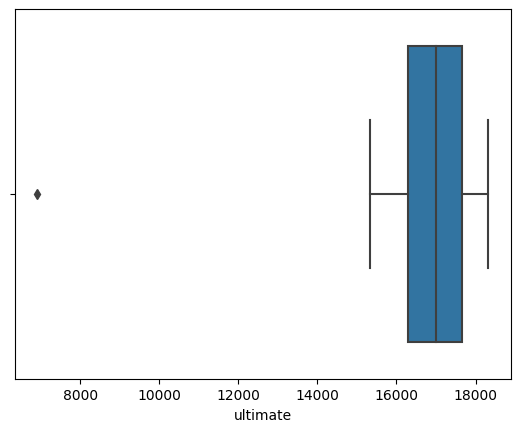

In [59]:
# Traza un diagrama de caja para visualizar la distribución de mb usados mensualmente para plan ultimate
sns.boxplot(surf_ultimate_mb['ultimate'])

#### Conclusiones
La cantidad de internet que consumen los usuarios si depende del plan que tengas, se ve que los que tienen el plan ultimate, que es el que tiene más gb usan mayor cantidad de gb al mes, sin embargo hay varios del plan surf que usan más cantidad de gb que las que tienen incluidas en el plan. La mayoria de los usuarios usa entre 15 y 20 gb mesuales

## Ingreso

In [60]:
#Filtrar mi archivo por plan y obtengo el ingreso mesual para cada uno
ingresos_ultimate=final_consumo[final_consumo['plan_name']=='ultimate'][['month','total_pay']]
ingresos_ultimate=ingresos_ultimate.groupby(['month'])['total_pay'].sum()

ingresos_surf=final_consumo[final_consumo['plan_name']=='surf'][['month','total_pay']]
ingresos_surf=ingresos_surf.groupby(['month'])['total_pay'].sum()

#Se crea un dataframe con los datos de los ingresos mensuales totales para cada plan
ingresos_totales=pd.concat([ingresos_ultimate,ingresos_surf],axis=1).reset_index()

ingresos_totales.columns=['month','ultimate','surf']


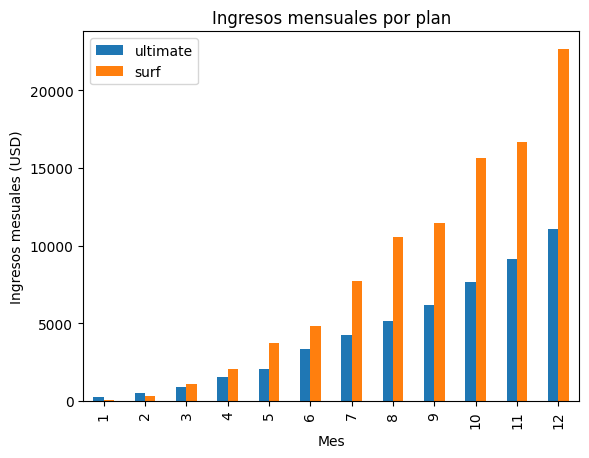

In [61]:
ingresos_totales.plot(kind='bar',x='month', title='Ingresos mensuales por plan', xlabel='Mes',ylabel='Ingresos mesuales (USD)')
plt.legend(['ultimate','surf'])
plt.show()

In [62]:
#Se obtiene la media y la varianza de los ingresos mensuales para cada plan 
ingresos_surf_mean=ingresos_totales['surf'].mean()
ingresos_surf_varianza=np.var(ingresos_totales['surf'])

ingresos_ultimate_mean=ingresos_totales['ultimate'].mean()
ingresos_ultimate_varianza=np.var(ingresos_totales['ultimate'])

print (f'La media de los ingresos mensuales para el  plan surf es:{ingresos_surf_mean}')
print (f'La varianza de los ingresos mensuales para el plan surf es:{ingresos_surf_varianza}')
print()
print (f'La media de los ingresos mensuales para el  plan ultimate es:{ingresos_ultimate_mean}')
print (f'La varianza de los ingresos mensuales para el plan ultimate es:{ingresos_ultimate_varianza}')

La media de los ingresos mensuales para el  plan surf es:8052.598333333334
La varianza de los ingresos mensuales para el plan surf es:50040370.048897244

La media de los ingresos mensuales para el  plan ultimate es:4342.916666666667
La varianza de los ingresos mensuales para el plan ultimate es:11732139.076388888


<AxesSubplot:xlabel='surf'>

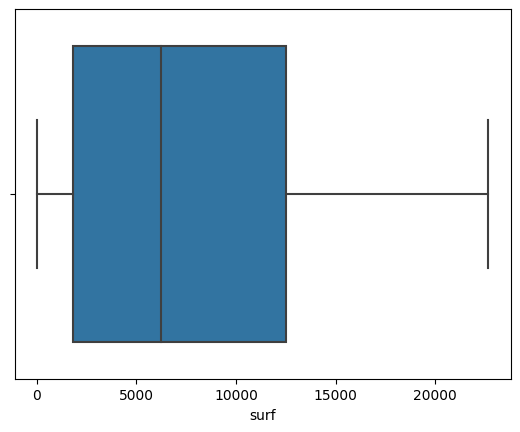

In [63]:
# Traza un diagrama de caja para visualizar la distribución ingresos para plan surf
sns.boxplot(ingresos_totales['surf'])

<AxesSubplot:xlabel='ultimate'>

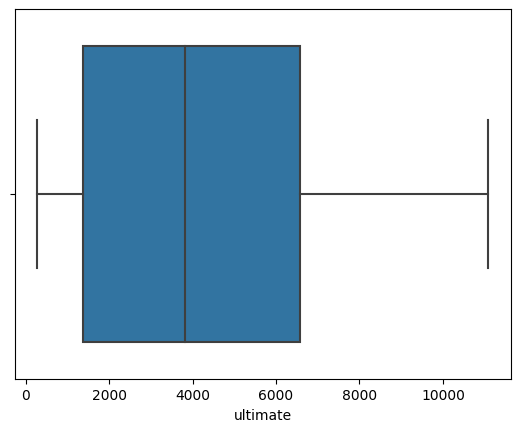

In [64]:
# Traza un diagrama de caja para visualizar la distribución de ingresos para plan ultimate
sns.boxplot(ingresos_totales['ultimate'])

#### Conclusiones
Se puede ver que los ingresos mensuales para cada plan iban ingrementado cada mes. Del mes 1 al mes 6 los ingresos que la compañia tenía por cada plan eran muy similares, sin embargo a partir del mes 7 los ingresos que la compañia optenía del plan surf eran mucho mayores que lo que obtenían del plan ultimate. Comparando  la media de cada plan se observa que los ingresos por el plan surf son casi del doble de lo que otiene por el plan ultimate. 

## Prueba las hipótesis estadísticas

### Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.

Hipótesis nula: Los ingresos promedio del plan Ultimate y Surf son iguales

Hipótesis alternativa: Los ingresos promedio del plan Ultimate es diferente a la del plan Surf

Prueba estadística: hipótesis sobre la igualdad de las medias de 2 poblaciones
Valor alpha: 5%

In [65]:
# Prueba las hipótesis
alpha=0.05
sample1=final_consumo[final_consumo['plan_name']=='ultimate'][['total_pay']]
sample2=final_consumo[final_consumo['plan_name']=='surf'][['total_pay']]

results=st.ttest_ind(sample1,sample2, equal_var=False)

#impirmir el valor p
print('valor p:', results.pvalue)

#compara los valores p obtenidos con el nivel de significación estadística):
if results.pvalue<alpha:
    print('Rechaza la hipótesis nula')
else:
    print('No se puede rechazar la hipótesis')

valor p: [3.14002226e-13]
Rechaza la hipótesis nula


### Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

Hipótesis nula: Los ingresos promedio de los usuarios del área NY-NJ son iguales al de los usuarios de otras regiones

Hipótesis alternativa: Los ingresos promedio de los usuarios del área NY-NJ son diferentes al de los usuarios de otras regiones.

Prueba estadística: hipótesis sobre la igualdad de las medias de 2 poblaciones

In [66]:
# Prueba las hipótesis

alpha=0.05
sample1=final_consumo[final_consumo['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA'][['total_pay']]
sample2=final_consumo[final_consumo['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA'][['total_pay']]
# probar la hipótesis de que las medias de los dos planes independientes son iguales
results=st.ttest_ind(sample1,sample2, equal_var=False)

#impirmir el valor p
print('valor p:', results.pvalue)

#compara los valores p obtenidos con el nivel de significación estadística):
if results.pvalue<alpha:
    print('Rechaza la hipótesis nula')
else:
    print('No se puede rechazar la hipótesis')

valor p: [0.03978851]
Rechaza la hipótesis nula


## Conclusión general

Lo primero que se realizo es visualizar los archivos que datos tenían y que tipo estaban, los datos que eran de fechas se cambioron a tipo datetime, para poder manejar esta información mejor y poder de una manera más facil los gastos de cada usuario mensualmente. También habían unos datos de precios que estaban como enteros que los pase a float ya que habían valores que eran con decimales. Debido a que la compañia aproxima los segundo de las llamandas a minutos se calculo el total de minutos que la compañia con base en esto, también se cambio los mb que gastan los usuarios a gb y también se redondeo hacia arriba para saber gastaron más de lo que incluida el plan y poderles cobrar por gb adicional. Con base en lo que gastaron mensualmente cada usuario se obtuvo el precio final que pago cada usuario. 

Analizando lo que uso de minutos, mensajes y GB cada usuario de los dos planes se ve que no hay mucha diferencia en la cantidad de uso de minutos y mensajes en los usuarios del plan ultimate y surf. No se observo que gastaran más de lo que incluye el plan. Se observa una diferencia mayor en la cantidad de GB usadas en los usuarios de cada plan. Los que tienen el plan ultimate usan más GB que los que tienen el plan surf. Sin embargo si se observan que hay usuarios que tienen el plan surf y se pasan de las GB que tienen incluidas en el plan. 

Con base en la prueba de hipótesis estadística de que son diferentes los ingresos promedio de los planes ultimate y surf, se tomo la hipótesis nula como: Los ingresos promedio del plan Ultimate y Surf son iguales. Se puso un valor alpha de 5%. Obtuvimos un valor p de 3.14e-13, esto nos dice que la hipótesis nula se rechaza, por lo tanto los ingresos por el plan ultimate y surf no son iguales. 


Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones. Para esta se tomo como hipótesis nula que  Los ingresos promedio de los usuarios del área NY-NJ son iguales al de los usuarios de otras regiones. Se obtuvo un valor p de 0.03 por lo que se rechaza la hipótesis nula. De lo que se puede decir que el ingreso promedio de los usuarios de NY-NJ si difiere al de los usuarios de otras regiones.  